In [1]:
import pandas as pd
import pmxNCMC
import numpy as np
from pathlib import Path
import pymbar

from scipy.stats import sem
import matplotlib.pyplot as plt

# Question
In state A, it's a normal 2-pentene. In state B, the dihedrals on the double bond are removed. We are calculating this free energy with different starting structure. If the enhance sampling works, 2 starting structures should converge to the same value.

In [2]:
T = 323.0

# load csv

In [3]:
base_t = Path("01-trans")
df_t = []
for p in base_t.glob("rep_?/md.csv"):
    df = pd.read_csv(p)
    if len(df) == 400:
        df_t.append(df)


In [4]:
base_c = Path("02-cis")
df_c = []
for p in base_c.glob("rep_?/md.csv"):
    df = pd.read_csv(p)
    if len(df) == 401:
        df_c.append(df)

In [5]:
kBT      = pmxNCMC.util.kB_kj_mol * T
kBT_kcal = pmxNCMC.util.kB_kcal_mol * T

# Estimate $\Delta G$

In [6]:
def freeE(n_start, n_end, df_t, df_c):
    """
    take the [n_start:n_end] sample and estimate the free E
    """
    dG_t = []
    dG_c = []
    for df_list, dG_list in ((df_t, dG_t),(df_c, dG_c)):
        for df in df_list:
            work01 = df[df.columns[1]][n_start:n_end]
            work10 = df[df.columns[2]][n_start:n_end]
            res = pymbar.other_estimators.bar(work01/kBT, work10/kBT)
            dG = res["Delta_f"]
            dGe = res["dDelta_f"]
            dG_list.append(dG*kBT_kcal)
    return dG_t, dG_c


In [7]:
x_list = np.arange(20, 401, 20)
re= {
    "t_dG_ave":[],
    "t_dG_sem":[],
    "c_dG_ave":[],
    "c_dG_sem":[],
}
t_dG_ave = []
t_dG_sem = []
c_dG_ave = []
c_dG_sem = []
for n in x_list:
    dG_t, dG_c = freeE(n//4,n, df_t, df_c)
    t_dG_ave.append(np.mean(dG_t))
    t_dG_sem.append(sem(dG_t))
    c_dG_ave.append(np.mean(dG_c))
    c_dG_sem.append(sem(dG_c))
re["x"] = x_list
re["t_dG_ave"] = np.array(t_dG_ave)
re["t_dG_sem"] = np.array(t_dG_sem)
re["c_dG_ave"] = np.array(c_dG_ave)
re["c_dG_sem"] = np.array(c_dG_sem)

Text(0.5, 1.0, 'Convergence Check')

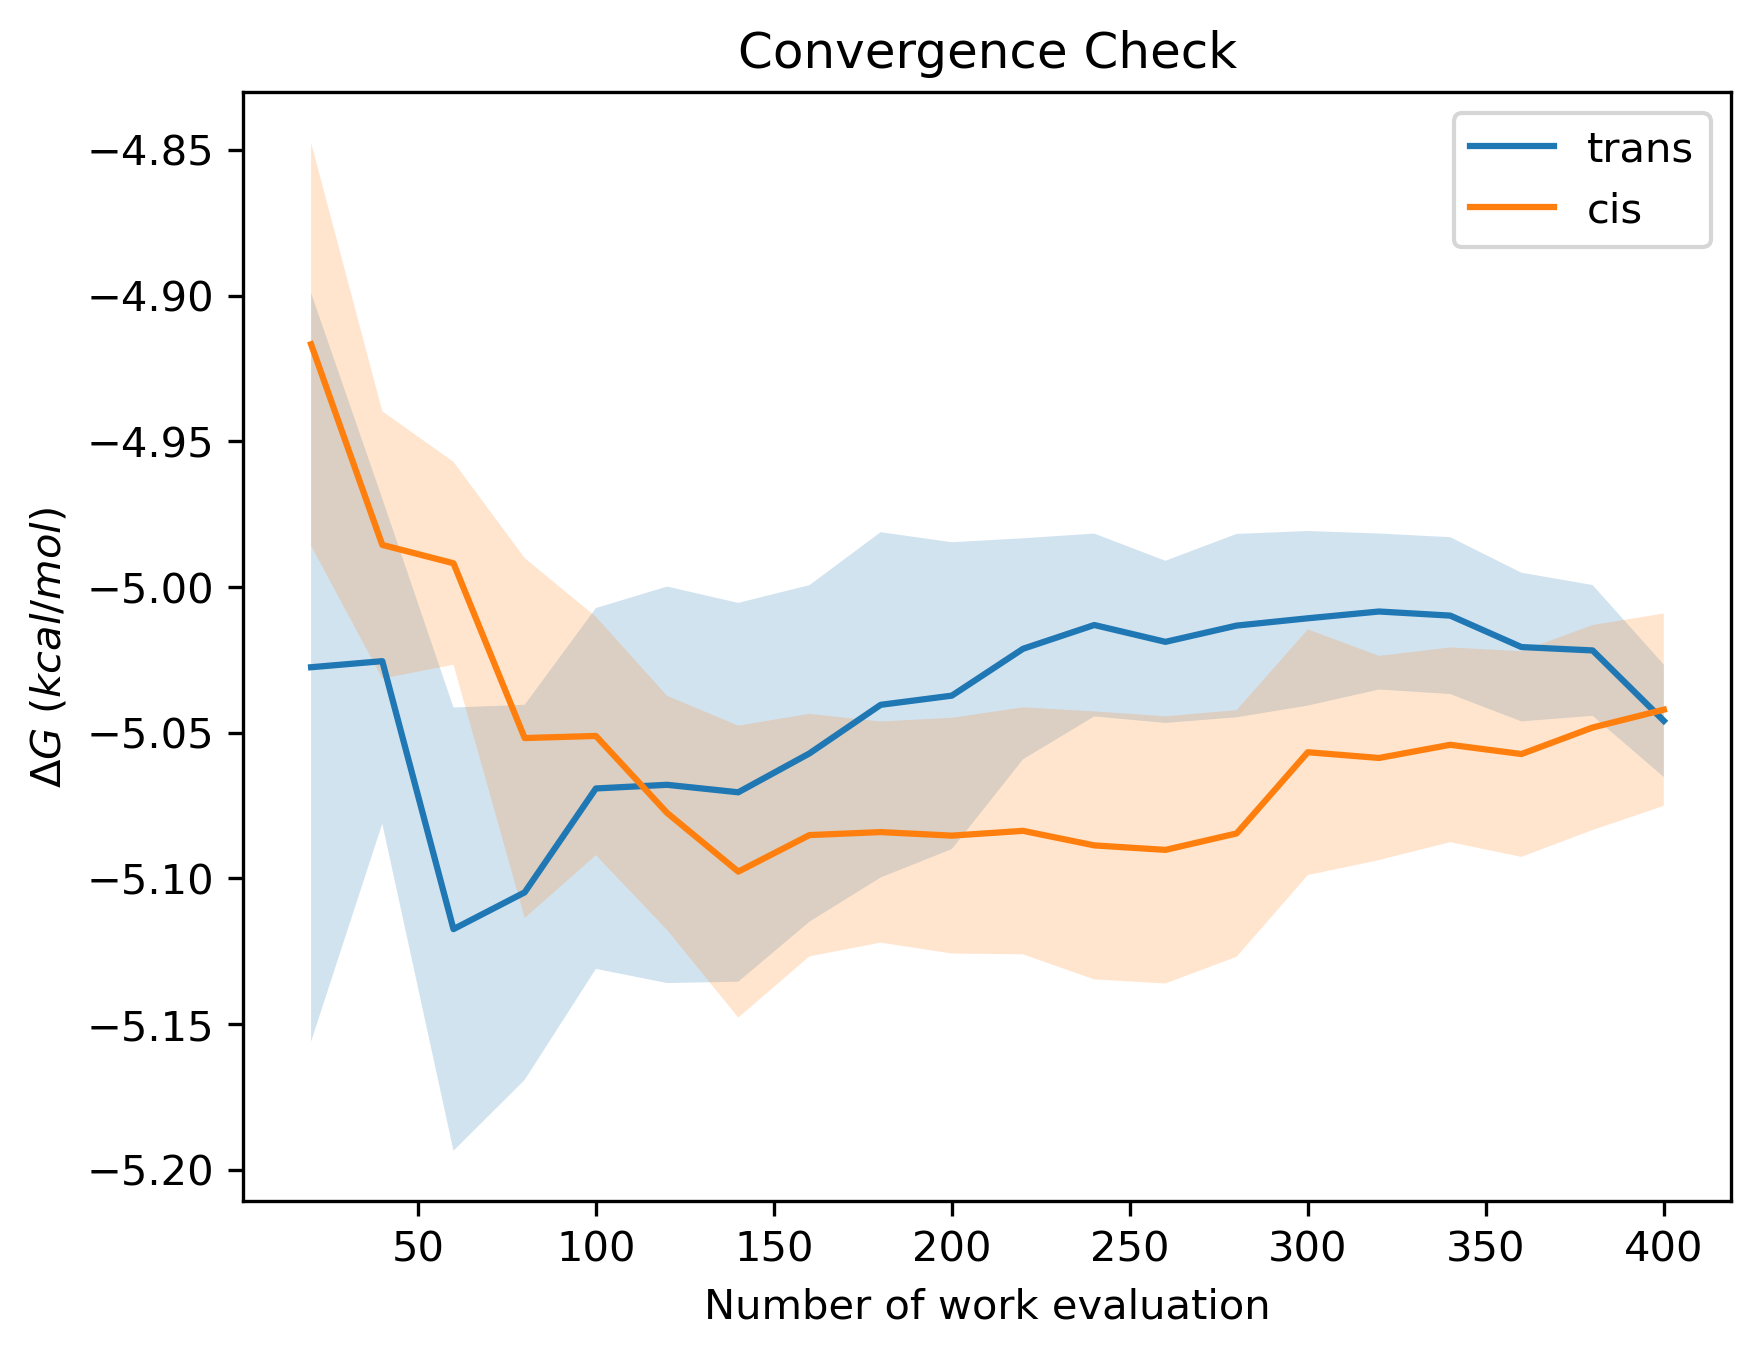

In [8]:
fig, ax = plt.subplots(1,1, dpi=300)
ax.plot(x_list, re["t_dG_ave"], label="trans")
ax.fill_between(x_list, re["t_dG_ave"] - re["t_dG_sem"], re["t_dG_ave"] + re["t_dG_sem"], alpha=0.2)
ax.plot(x_list, re["c_dG_ave"], label="cis")
ax.fill_between(x_list, re["c_dG_ave"] - re["c_dG_sem"], re["c_dG_ave"] + re["c_dG_sem"], alpha=0.2)
ax.legend()

ax.set_xlabel("Number of work evaluation")
ax.set_ylabel(r"$\Delta G\ (kcal/mol)$")
ax.set_title("Convergence Check")


# load results without REX

In [9]:
base = Path("/home/chui/E29Project-2023-04-11/104-NCMC/benchmark/05-2-pentene/01-pmx-old")
w_t_list = []
w_c_list = []
w_B_list = []
for rep in range(10):
    work_t = np.genfromtxt(base / f"rep_{rep}/01-trans/BAR/integA.dat", usecols=(1,))
    work_c = np.genfromtxt(base / f"rep_{rep}/02-cis/BAR/integA.dat",   usecols=(1,))
    work_B = np.genfromtxt(base / f"rep_{rep}/01-trans/BAR/integB.dat", usecols=(1,))
    w_t_list.append(work_t)
    w_c_list.append(work_c)
    w_B_list.append(work_B)
w_t_list = np.array(w_t_list)
w_c_list = np.array(w_c_list)
w_B_list = np.array(w_B_list)
print(w_t_list.shape)
print(w_c_list.shape)
print(w_B_list.shape)

(10, 400)
(10, 400)
(10, 400)


In [10]:
def freeE2(w_t_list, w_c_list, w_B_list, n_start, n_end):
    dG_t = []
    dG_c = []
    for work_t, work_c, work_B in zip(w_t_list, w_c_list, w_B_list):
        res = pymbar.other_estimators.bar(work_t[n_start:n_end]/kBT, -work_B[n_start:n_end]/kBT)
        dG_t.append(res["Delta_f"] * kBT_kcal)
        res = pymbar.other_estimators.bar(work_c[n_start:n_end]/kBT, -work_B[n_start:n_end]/kBT)
        dG_c.append(res["Delta_f"] * kBT_kcal)
    return dG_t, dG_c
    

In [11]:
x_list = np.arange(20, 401, 20)
pmx = {
    "t_dG_ave":[],
    "t_dG_sem":[],
    "c_dG_ave":[],
    "c_dG_sem":[],
}
t_dG_ave = []
t_dG_sem = []
c_dG_ave = []
c_dG_sem = []
for n in x_list:
    dG_t, dG_c = freeE2(w_t_list, w_c_list, w_B_list, n//2, n)
    t_dG_ave.append(np.mean(dG_t))
    t_dG_sem.append(sem(dG_t))
    c_dG_ave.append(np.mean(dG_c))
    c_dG_sem.append(sem(dG_c))
pmx["x"] = x_list
pmx["t_dG_ave"] = np.array(t_dG_ave)
pmx["t_dG_sem"] = np.array(t_dG_sem)
pmx["c_dG_ave"] = np.array(c_dG_ave)
pmx["c_dG_sem"] = np.array(c_dG_sem)

In [12]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

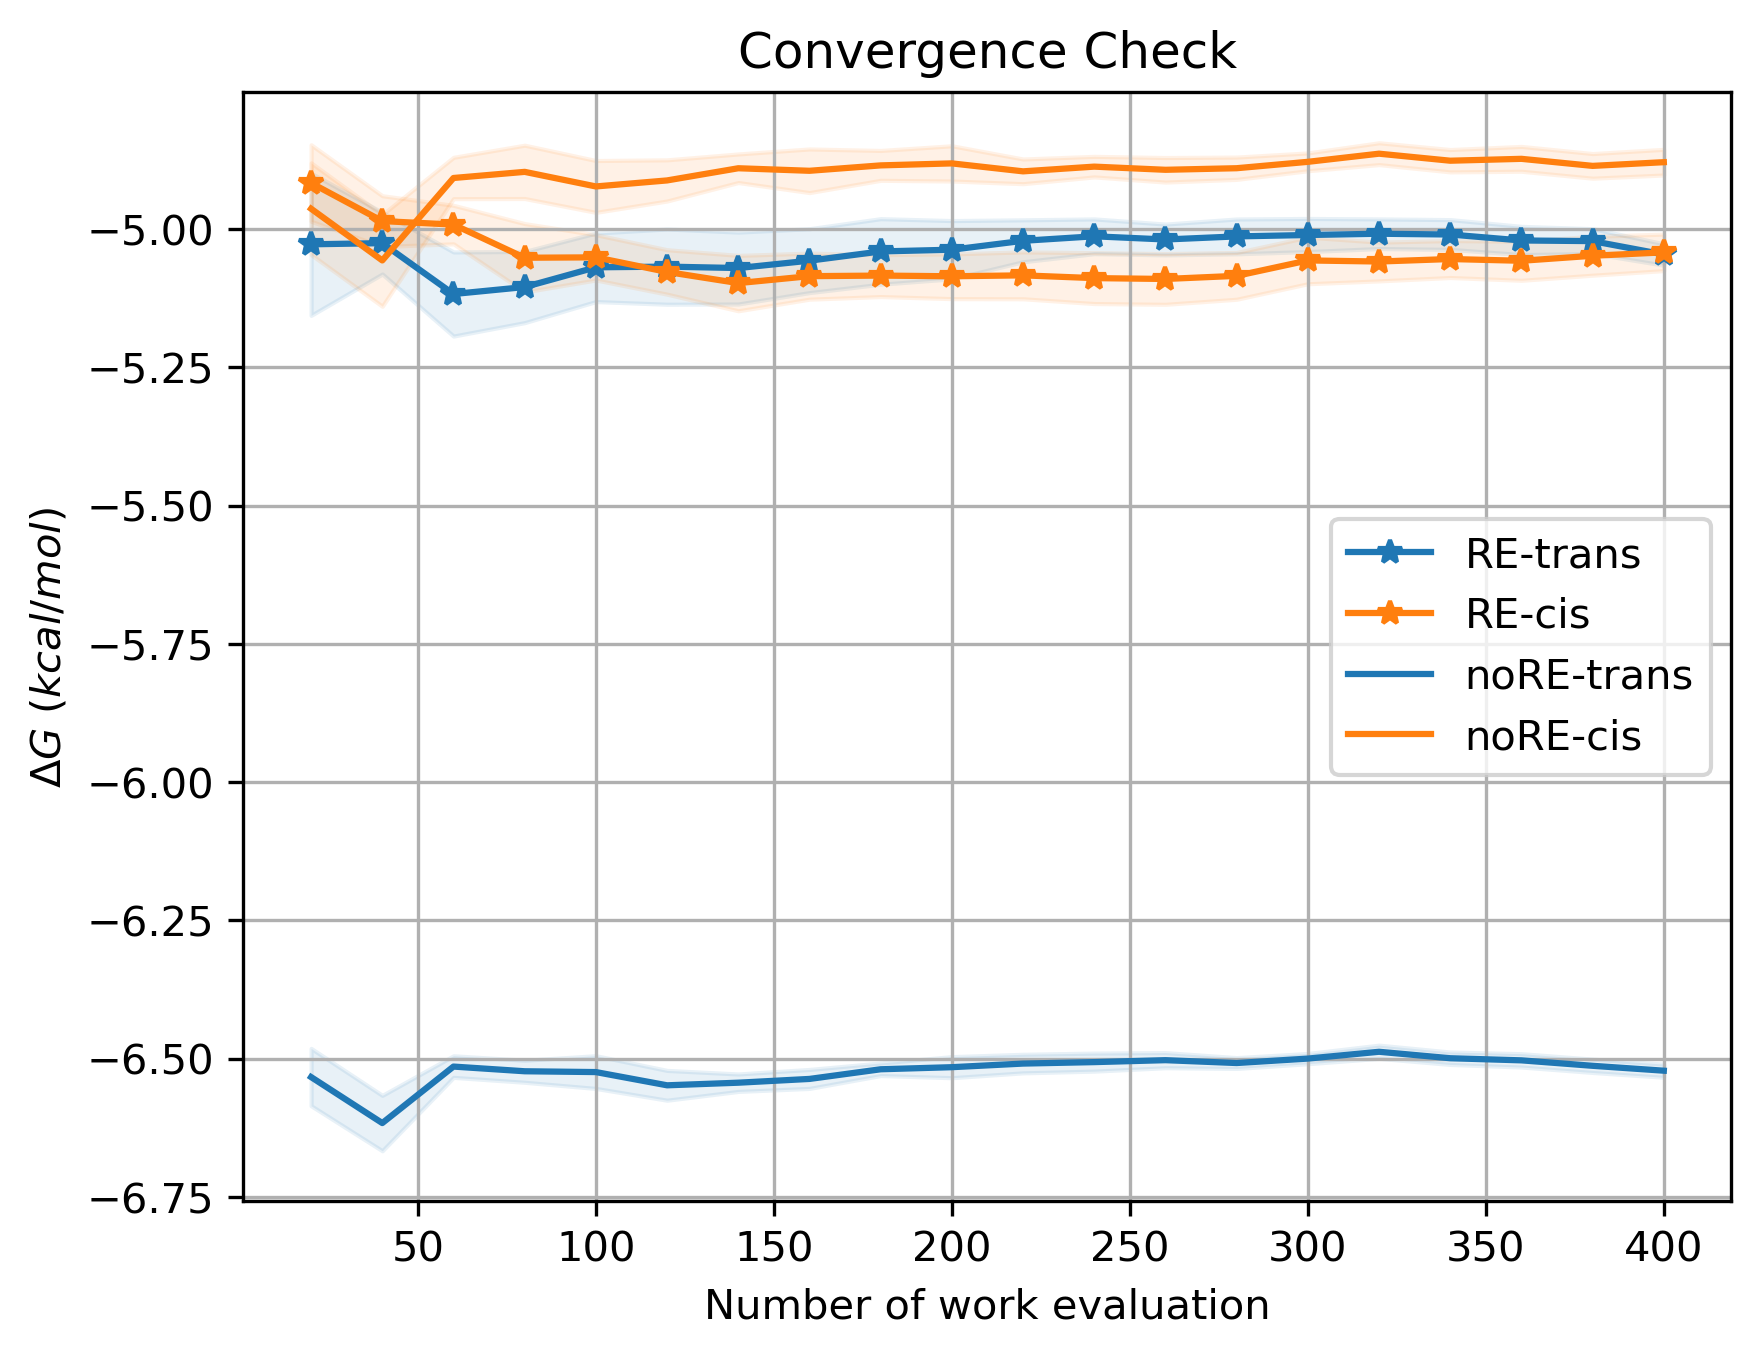

In [16]:
fig, ax = plt.subplots(1,1, dpi=300)
ax.plot(re["x"], re["t_dG_ave"], label="RE-trans", marker='*', color=colors[0])
ax.fill_between(re["x"], re["t_dG_ave"] - re["t_dG_sem"], re["t_dG_ave"] + re["t_dG_sem"], alpha=0.1, color=colors[0])
ax.plot(re["x"], re["c_dG_ave"], label="RE-cis",   marker='*', color=colors[1])
ax.fill_between(re["x"], re["c_dG_ave"] - re["c_dG_sem"], re["c_dG_ave"] + re["c_dG_sem"], alpha=0.1, color=colors[1])

ax.plot(pmx["x"], pmx["t_dG_ave"], label="noRE-trans", color=colors[0])
ax.fill_between(pmx["x"], pmx["t_dG_ave"] - pmx["t_dG_sem"], pmx["t_dG_ave"] + pmx["t_dG_sem"], alpha=0.1, color=colors[0])
ax.plot(pmx["x"], pmx["c_dG_ave"], label="noRE-cis"  , color=colors[1])
ax.fill_between(pmx["x"], pmx["c_dG_ave"] - pmx["c_dG_sem"], pmx["c_dG_ave"] + pmx["c_dG_sem"], alpha=0.1, color=colors[1])


ax.legend()

ax.set_xlabel("Number of work evaluation")
ax.set_ylabel(r"$\Delta G\ (kcal/mol)$")
ax.set_title("Convergence Check")

ax.grid()

fig.savefig("convergence.jpeg", bbox_inches='tight')

# What about the work distribution?

In [14]:
bins = np.linspace(-9.5, -1, 35)

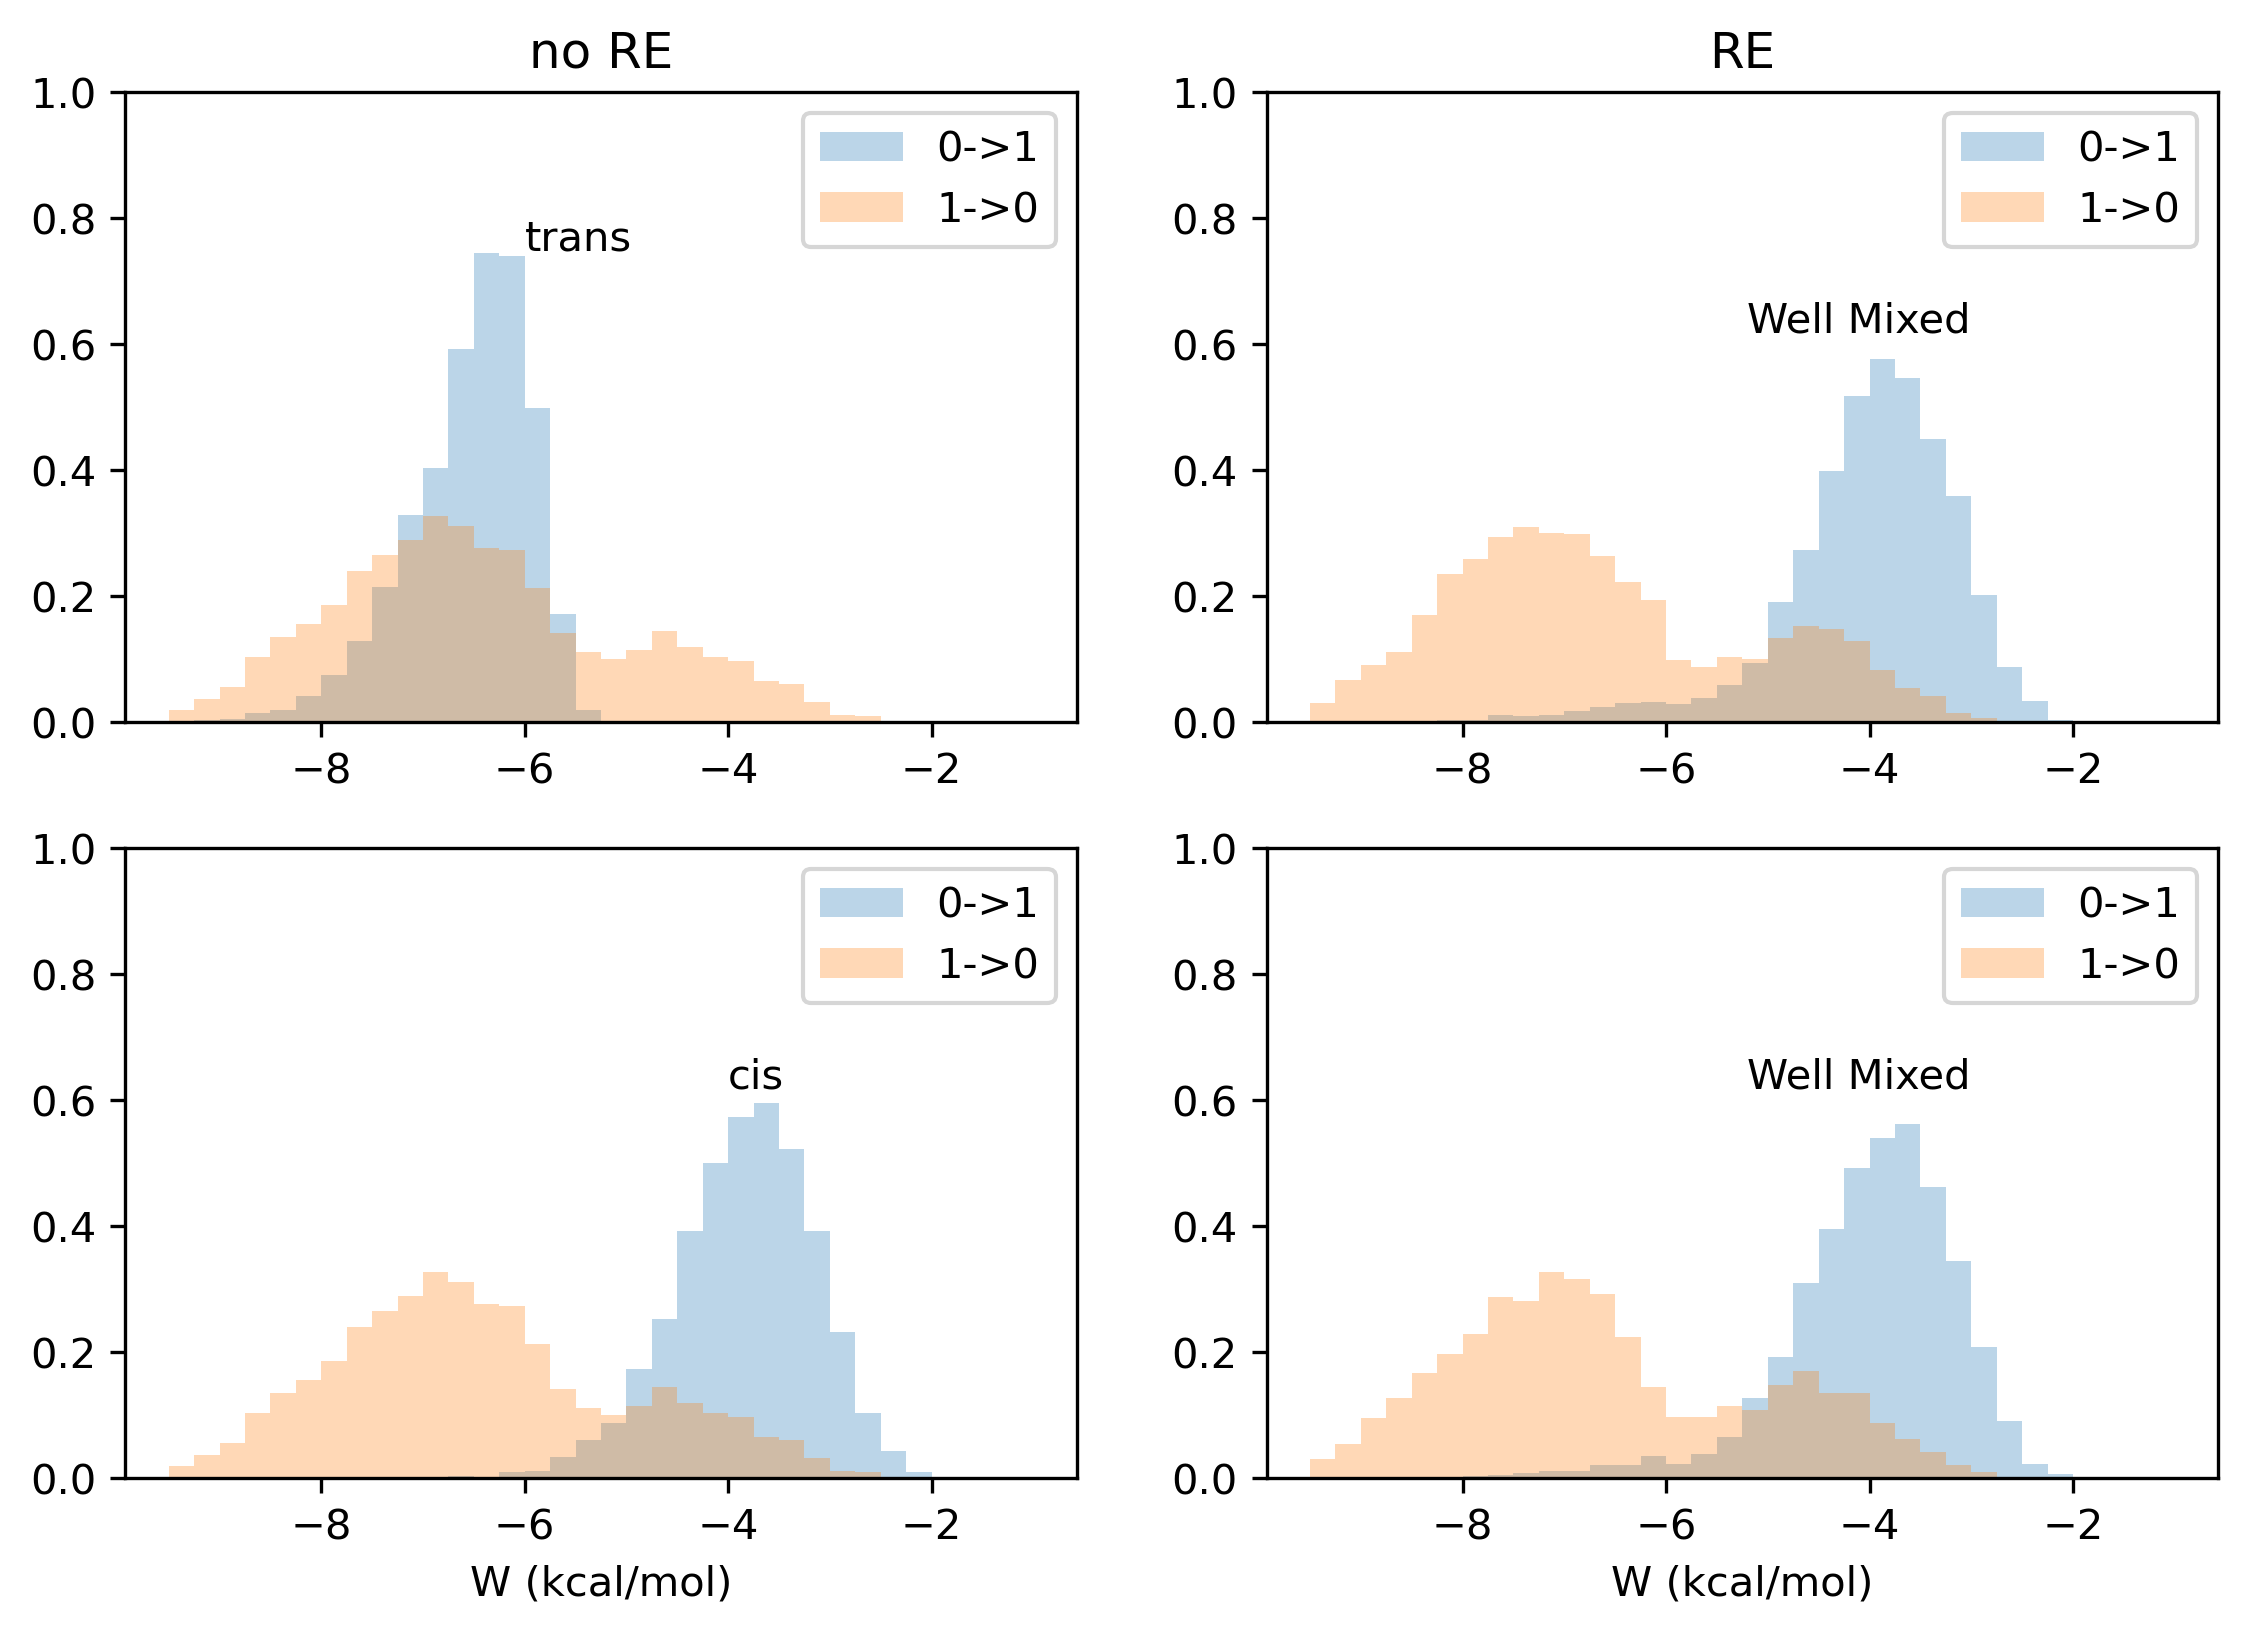

In [19]:
fig, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2, dpi=300, figsize=(9,6))

ax1.hist(w_t_list.reshape(-1)/kBT*kBT_kcal, bins=bins, density=True, alpha=0.3, label="0->1")
ax1.hist(w_B_list.reshape(-1)/kBT*kBT_kcal, bins=bins, density=True, alpha=0.3, label="1->0")

ax3.hist(w_c_list.reshape(-1)/kBT*kBT_kcal, bins=bins, density=True, alpha=0.3, label="0->1")
ax3.hist(w_B_list.reshape(-1)/kBT*kBT_kcal, bins=bins, density=True, alpha=0.3, label="1->0")

ax1.text(-6.0, 0.75, "trans",)
ax3.text(-4.0, 0.62, "cis",)

ax2.hist( np.array([df["Work_01 (kJ/mol)"] for df in df_t]).reshape(-1)/kBT*kBT_kcal, bins=bins, density=True, alpha=0.3, label="0->1")
ax2.hist(-np.array([df["Work_10 (kJ/mol)"] for df in df_t]).reshape(-1)/kBT*kBT_kcal, bins=bins, density=True, alpha=0.3, label="1->0")

ax4.hist( np.array([df["Work_01 (kJ/mol)"] for df in df_c]).reshape(-1)/kBT*kBT_kcal, bins=bins, density=True, alpha=0.3, label="0->1")
ax4.hist(-np.array([df["Work_10 (kJ/mol)"] for df in df_c]).reshape(-1)/kBT*kBT_kcal, bins=bins, density=True, alpha=0.3, label="1->0")

ax1.set_title("no RE")
ax2.set_title("RE")

ax3.set_xlabel("W (kcal/mol)")
ax4.set_xlabel("W (kcal/mol)")

ax2.text(-5.2, 0.62, "Well Mixed")
ax4.text(-5.2, 0.62, "Well Mixed",)

for ax in (ax1, ax2, ax3,ax4):
    ax.set_ylim(0,1.0)
    ax.legend()


fig.savefig("work_distribution.jpeg", bbox_inches='tight')